# Energy Management in Buildings: Dynamic Modeling of building (4h)
### author: stephane.ploix@grenoble-inp.fr

- __Student name(s)__:

- __Teaching program followed__: 

**Your answers to questions in assignment files, must be returned by one week after the latest session.**

__Prerequisites:__ Basic knowledge about modeling physical systems, plus basic skills of the Python language.

__Advice:__ Each question has a unique number so that you can use any kind of document to put your answers, providing the question numbers are mentioned. Don't wait for the end to test your way of collecting results. You can work directly in the notebook but be careful not to loose your responses (copy and export them regularly).

The lecture is designed as a tutorial to follow with an estimation of the needed time to solve each problem. It is composed of Jupyter notebooks, named notebookx_XXX.ipynb and example python files, located at the root folder. The core well-documented Python code is located in the _buildingenergy_ folder, but it's for curious people (it's not needed for solving the problems of the notebooks). Data like weather files (extension '.json'), thermal and physical properties (file named propertiesDB.xlsx) are located in the _data_ folder. When a file is generated, it will be located in the _result_ folder like physical parameters for simplified models (extension '.p'). All these folders can be reset thanks to the _"setup.ini" configuration file__

Regarding your working environment, it is recommended to:
- Install the latest available version of Python (3.9 minimum but preferably 3.11) activating the checkbox "Install in the path of your operating system", either directly from the [Python distribution site](https://www.python.org/downloads/), or by using [Anaconda](https://www.anaconda.com/products/distribution), that embeds Python together with additional useful scientific librairies.
- Load and install the latest version of (Visual Studio code)[https://code.visualstudio.com] for your operating system and load from the VS studio extensions: Python from Microsoft and Jupyter from Microsoft.
- Go to the [git site of the building energy project](https://gricad-gitlab.univ-grenoble-alpes.fr/ploixs/buildingenergy) and download it as a zip file. Unzip and open with Visual Studio code. If the Internet connection is not tool slow, you can access a [MyMinder](https://bit.ly/3QbtIPK) site, where the code can be remote remotely.
- In the terminal of Visual Studio code, you can installed the modules dependencies using ```python3.X -m pip install -r requirements.txt```where x stands for the number of the Python version selected in Visual Studio code.
- Open the working folder with the unzipped files and double-click on the notebook you want. 
- Execute each cell following the proposed order.
  
_______________________________________________

# 1. Introduction [10min]

The static model does not take into account thermal inertia and transcient behavior of CO2 concentration: thermal capacitance but also room volume were not taken into account. Consequently, the office temperature and CO2 concentration were reacting immediately... the resulting simulation was looking very noisy.

We are going to introduce the transcient behaviour firstly in the model of the office temperature and secondly in the one of CO2 concentration.

We are going to model the dynamic behavior of H358 office and compare it to actual measurements.

Here is a 3 capacitances model of the office. A state space model is deduced as an illustrative example of the procedure.

![](img3/RCmodel.png)

The model with 3 capacitances (we will assume firstly that a wall can be modeled by a single capacitance $C=\rho C_p V$, with $\rho$ the volumic mass, $C_p$ the specific heat and $V$ the wall volume, and we will check later if it's an acceptable assumption) is given by:

$$
\varphi_{cor}+\varphi_{in}=\varphi_{i1}+\varphi_{i2}+\varphi_{air}+\varphi_{out}\\
T_{cor}-T_{in}=R_{cor}\varphi_{cor}\\
T_{in}-T_{out}=R_{out}\varphi_{out}\\
T_{in}-\tau_{1}=R_{i1}\varphi_{i1}\\
T_{in}-\tau_{2}=R_{i2}\varphi_{i2}\\
C_{i1}\frac{d\tau_1}{dt}=\varphi_{i1}\\
C_{i2}\frac{d\tau_2}{dt}=\varphi_{i2}\\
C_{air}\frac{dT_{in}}{dt}=\varphi_{air}\\
$$

It can be reformulated as:
$$
C_{i1}\frac{d\tau_1}{dt}=-\frac{\tau_{1}}{R_{i1}}+\frac{T_{in}}{R_{i1}}\\
C_{i2}\frac{d\tau_2}{dt}=-\frac{\tau_{2}}{R_{i2}}+\frac{T_{in}}{R_{i2}}\\
C_{air}\frac{dT_{in}}{dt}=-\frac{1}{R}T_{in}+\frac{\tau_{1}}{R_{i1}}+\frac{\tau_{2}}{R_{i2}}+\frac{T_{out}}{R_{out}}+\frac{T_{cor}}{R_{cor}}+\varphi_{in}\\
\frac{1}{R}=\frac{1}{R_{cor}}+\frac{1}{R_{i1}}+\frac{1}{R_{i2}}+\frac{1}{R_{out}}
$$

and the resulting state space model is given by:
$$
\frac{d}{dt}\begin{bmatrix} \tau_1\\ \tau_2 \\ T_{in} \end{bmatrix}=
\begin{bmatrix} -\frac{1}{R_{i1}C_{i1}} & 0 & \frac{1}{R_{i1}C_{i1}} \\
0 & -\frac{1}{R_{i2}C_{i2}} & \frac{1}{R_{i2}C_{i2}}\\
\frac{1}{R_{i1}C_{air}}& \frac{1}{R_{i2}C_{air}}& -\frac{1}{RC_{air}}\\
\end{bmatrix}
\begin{bmatrix} \tau_1\\ \tau_2 \\ T_{in} \end{bmatrix}+
\begin{bmatrix} 0 & 0 & 0 \\ 0 & 0 & 0 \\ \frac{1}{R_{cor}C_{air}} & \frac{1}{R_{out}C_{air}} & \frac{1}{C_{air}}\end{bmatrix}
\begin{bmatrix}T_{cor}\\T_{out}\\\varphi_{in} \end{bmatrix}
$$

However, the air capacitance yields fast dynamics which are much faster than the 1 hour sample time we are using for generating energy strategies. Let's neglect the air capacitance and re-calculate the model. We consider that $RC_{air}$ is small and consequently that $\frac{dT_{in}}{dt}=0$. It leads to a 2nd order model (2 derivatives):
$$
C_{i1}\frac{d\tau_1}{dt}=-\frac{\tau_{1}}{R_{i1}}+\frac{T_{in}}{R_{i1}}\\
C_{i2}\frac{d\tau_2}{dt}=-\frac{\tau_{2}}{R_{i2}}+\frac{T_{in}}{R_{i2}}\\
T_{in}=\frac{R}{R_{i1}}\tau_{1}+\frac{R}{R_{i2}}\tau_{2}+\frac{R}{R_{cor}}T_{cor}+\frac{R}{R_{out}}T_{out}+R\varphi_{in}
$$

that can be rewritten as:
$$
C_{i1}\frac{d\tau_1}{dt}=\frac{R-R_{i1}}{R_{i1}^2}\tau_{1}+\frac{R}{R_{i1}R_{i2}}\tau_{2}+\frac{R}{R_{i1}R_{cor}}T_{cor}+\frac{R}{R_{i1}R_{out}}T_{out}+\frac{R}{R_{i1}}\varphi_{in}\\
C_{i2}\frac{d\tau_2}{dt}=\frac{R}{R_{i1}R_{i2}}\tau_{1}+\frac{R-R_{i2}}{R_{i2}^2}\tau_{2}+\frac{R}{R_{i2}R_{cor}}T_{cor}+\frac{R}{R_{i2}R_{out}}T_{out}+\frac{R}{R_{i2}}\varphi_{in}\\
T_{in}=\frac{R}{R_{i1}}\tau_{1}+\frac{R}{R_{i2}}\tau_{2}+\frac{R}{R_{cor}}T_{cor}+\frac{R}{R_{out}}T_{out}+R\varphi_{in}\\
$$

and reformulated as a state space model:
$$
\frac{d}{dt}\begin{bmatrix} \tau_1\\ \tau_2 \end{bmatrix}=
\begin{bmatrix} \frac{R-R_{i1}}{R_{i1}^2C_{i1}} & \frac{R}{R_{i1}R_{i2}C_{i1}} \\
\frac{R}{R_{i1}R_{i2}C_{i2}} & \frac{R-R_{i2}}{R_{i2}^2C_{i2}}\\
\end{bmatrix}
\begin{bmatrix} \tau_1\\ \tau_2 \end{bmatrix}+
\begin{bmatrix} \frac{R}{R_{i1}R_{cor}C_{i1}} & \frac{R}{R_{i1}R_{out}C_{i1}} & \frac{R}{R_{i1}C_{i1}} \\ \frac{R}{R_{i2}R_{cor}C_{i2}} & \frac{R}{R_{i2}R_{out}C_{i2}} & \frac{R}{R_{i2}C_{i2}} \end{bmatrix}
\begin{bmatrix}T_{cor}\\T_{out}\\\varphi_{in} \end{bmatrix}\\
T_{in}=\begin{bmatrix} \frac{R}{R_{i1}} & \frac{R}{R_{i2}}\end{bmatrix}
\begin{bmatrix} \tau_1\\ \tau_2 \end{bmatrix}+
\begin{bmatrix}\frac{R}{R_{cor}} & \frac{R}{R_{out}} & R\end{bmatrix}
\begin{bmatrix}T_{cor}\\T_{out}\\\varphi_{in} \end{bmatrix}\\
$$

## 2. One capacitance model [1h]

Because we don't know whether 1 capacitance is not enough, establish the state model of a single capacitance model (let's say $C_{i1}$): it could corresponds to the main heavy wall in the office: the slab.

_your results>_



## 3. Estimation of capacitances [30min]

### 3.1 Single wall [20min]

Because the heat equation contains partial derivative in space and derivative wrt time, a single wall must be discretized in numerous layers, with theoretically a capacitance per layer. The number of derivative is huge and troubleshooting for us because of the huge number of parameters. However, we are going to try to approximate the main dynamics by 1 or 2 capacitances. Each resulting RC time constant is corresponding to a useful thickness of a layer with an significant effusivity: the capability of a material to exchange heat with its environment. This property combines the capability for storing heat ($\rho c_p$) with the capability for conducting heat ($\lambda$): 
$$E=\sqrt{\lambda \rho c_p }$$
in $W.\sqrt{sec}/m^2K$.

We have for instance (see [wikipedia](https://en.wikipedia.org/wiki/Thermal_effusivity)):

| Material | Thermal effusivity |
|----------|--------------------|
| Aluminum | 	23.7 | 
| Iron	| 15.9 | 
| Silicon	| 14.4 | 
| Ice | 	2.8 | 
| Concrete (dense) |  2.0 | 
| Water | 	1.6 | 
| Brick | 	0.99 - 1.6 | 
| PVC (polyvinyl chloride) | 	0.6 | 
| Plasterboard | 	0.38 | 
| Wood | 	0.26 | 
| Wool	|  0.07 | 
| Air	| 0.006 | 

If the inertia is related to a single wall or slab with a dominant effusive surface ($E\times S$), an active thickness $d$ can be defined: $d<d^*$ ($d^*$ the actual thickness). The active thickness is determining a thermal time constant $\tau_i$:
$$
R_i=\frac{d}{\lambda S}\\
C_i=\rho c_p d S\\
\tau_i = \frac{\rho c_p d^2}{\lambda}
$$
In order to estimate the active thickness, we are going to use the depth of penetration $d^+$, corresponding to the thickness were a sine signal with a period $T$ is attenuated by the Euler constant $e$: 
$$
d^+ = \sqrt{\frac{D T}{\pi}}
$$
where $D$ stands for the diffusivity: $D = \frac{\lambda}{\rho c_p}$, the capability of a material to transfer heat inside itself.

Let's consider the active thickness $d=d^+$ for the sake of interpretation. It comes out:
$$
\tau_i=\frac{T}{\pi}\\
d=\sqrt{D\tau_i}\le d^*\\
R_i=\frac{\sqrt{\tau_i}}{E S}\\
C_i= E S \sqrt{\tau_i}
$$

### 3.1.1 Estimation of $R_i$ and $C_i$

Considering the parameters of the concrete slab: $\lambda=1$, $\rho=2200$, $c_p=880$ and $S=21m^2$, determine the possible values for the parameters $R_i$ and $C_i$ according to different waves of length $T$? What is the limit for $T$?

__your results 3.1.1>__

### 3.1.2 Analyse the following curves and comment.

__your results 3.1.2>__

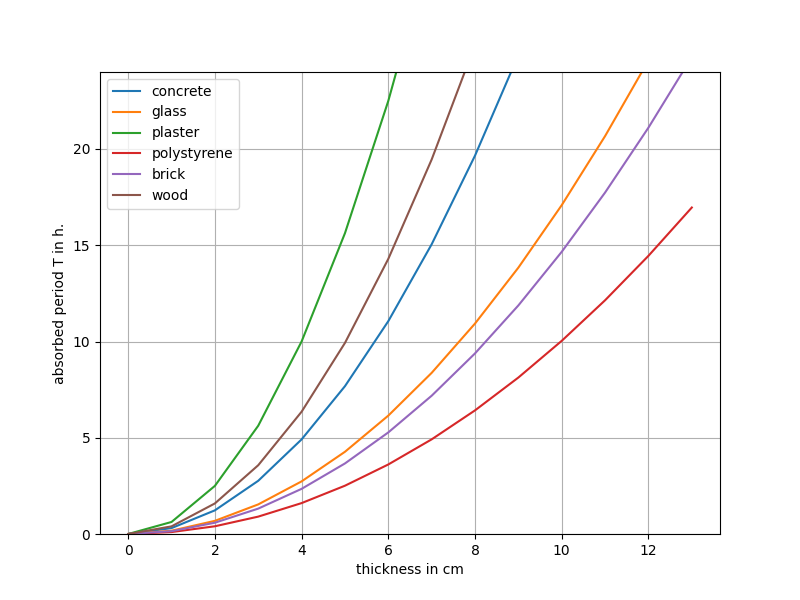

In [1]:
%matplotlib widget
from __future__ import annotations

import matplotlib.pyplot as plt
from buildingenergy.physics import Library
from math import sqrt

library  = Library()
library.store('concrete', 'thermal', 269)
library.store('glass', 'thermal', 267)
library.store('plaster', 'thermal', 265)
library.store('polystyrene', 'thermal', 145)
library.store('brick', 'thermal', 268)
library.store('wood', 'thermal', 277)

materials: tuple[str] = ('concrete', 'glass', 'plaster', 'polystyrene', 'brick', 'wood')

def Twave_hours(d_cm, D):
    return 3.14159*(d_cm/100)**2 / D / 3600

# def d(tau_i, diffusivity):
#     return 100* sqrt(diffusivity*tau_i*3600)

for material in materials:
    D: float = library.get(material)['diffusivity']
    ds_cm = [_ for _ in range(0,14)]
    plt.plot(ds_cm, [Twave_hours(d_cm, D) for d_cm in ds_cm])
plt.xlabel('thickness in cm')
plt.ylabel('absorbed period T in h.')
plt.ylim((0,24))
plt.grid()
plt.legend(materials)
plt.show()

### 3.2 Simulation of the results [10min]

Use your the state model you got in (2) together with the following code to simulate the resulting temperature for different $T_w$ and discuss it.

__your results 3.2>__

In [2]:
from numpy import matrix
from scipy.signal import cont2discrete
from math import sqrt

import sites.data_h358
import sites.model_h358

print('Loading data')
data_provider = sites.data_h358.make_h358_data_provider('01/04/2015', '01/07/2015', number_of_levels=3)
data_provider.parameters('Qoutdoor', 12/3600)
data_provider.parameters('Qcorridor', 12/3600)

h358_model_maker = sites.model_h358.H358BuildingModelMaker(data_provider, sample_time_in_seconds=3600)  # , parameters_levels=None
state_model = h358_model_maker.make_state_model(k=0)

Rout: float = h358_model_maker.ventilated_building.get_interface_thermal_resistance('office', 'outdoor')
Rcor: float = h358_model_maker.ventilated_building.get_interface_thermal_resistance('corridor', 'office')

Routvents: float = [1 / (1 / Rout + 1.005 * 1.26 * data_provider('Qoutdoor',k)) for k in range(len(data_provider))]

Tout: list[float] = data_provider('weather_temperature', k=None)
Tcor: list[float] = data_provider('Tcorridor', k=None)

datetimes = data_provider('datetime', k=None)
Pin: list[list[float]] = data_provider('Pheat_total', k=None) #for k in range(len(data_provider))]
data_provider.add_external_variable('Pheat', Pin)

office_simulated_temperature = []

Ts_hours: float = 1.2  # < 28h

surface: float = 21
thickness: float = 0.13
rho: float = 3200
Cp: float = 880
lbda: float = 1

Ri: float = sqrt(Ts_hours * 3600 / (lbda* rho * Cp * 3.14159)) / surface
Ci: float = surface * sqrt( rho * Cp * Ts_hours * 3600 / 3.14159)

R: float = 1 / (1 / Rcor + 1 / Ri + 1 / Rout)
A = matrix([[(R - Ri) / (Ri**2 * Ci)]])
B = matrix([[R / (Ri * Rcor * Ci), R / (Ri * Rout * Ci), R / (Ri * Ci)]]) # U = [Tcor, Tout, Pin]
C = matrix([[R / Ri]])
D = matrix([[R/Rcor, R/Rout, R]]) # U = [Tcor, Tout, Pin]
A, B, C, D, Tsample = cont2discrete((A, B, C, D), 3600, method='zoh')

Tin: list[float] = list()
X = matrix([[20]])
for k in range(len(datetimes)):
    U = matrix([[Tcor[k]], [Tout[k]], [Pin[k]]])
    Y = C * X + D * U
    Tin.append(Y[0,0])
    X = A * X + B * U

data_provider.add_external_variable('office_simulated_temperature', Tin)
data_provider.plot()

Loading data
variables read from file measurement file:
stringtime, epochtime, datetime, Toffice_wall, Tcorridor, Theater, Toffice_reference, office_CO2_concentration, corridor_CO2_concentration, zetaW7, zetaW9, window_opening, door_opening, power_block_east, power_block_west, power_stephane, power_khadija, power_audrey, power_stagiaire, humidity, Tyanis, occupancy, detected_motions, illuminance_old, illuminance_new, dT_heat, power_heater, heating_level, total_electric_power, actual_occupation, acoustic_pressure_dB, 
Variable zetaW7 has been removed
Variable zetaW9 has been removed
Variable humidity has been removed
Variable Tyanis has been removed
Variable occupancy has been removed
Variable power_heater has been removed
stringtime, epochtime, datetime, Toffice_wall, Tcorridor, Theater, Toffice_reference, office_CO2_concentration, corridor_CO2_concentration, window_opening, door_opening, power_block_east, power_block_west, power_stephane, power_khadija, power_audrey, power_stagiaire, 

SelectMultiple(description='Select variable to plot', options=('Toffice_wall', 'Tcorridor', 'Theater', 'Toffic…

Button(description='Plot', style=ButtonStyle())

Output()

__your results 3.2>__

# 4. CO2 dynamic model [30min]

Let’s now model the dynamic behavior of CO2.

We have:
$$
Q_{out} = Q_w^0+\zeta_wQ_w^1\\
Q_{cor} = Q_c^0+\zeta_dQ_c^1\\
V\frac{dC_{in}}{dt}=-(Q_{out}+Q_{cor})C_{in}+Q_{out}C_{out}+Q_{cor}C_{cor}+S_{CO2}n_{occ}\\
\frac{d}{dt}\begin{bmatrix}C_{in}\end{bmatrix}=\begin{bmatrix}-\frac{Q_{out}+Q_{cor}}{V} \end{bmatrix} \begin{bmatrix}C_{in}\end{bmatrix}+
\begin{bmatrix} \frac{Q_{cor}}{V} & \frac{Q_{out}}{V} & \frac{S_{CO2}}{V} \end{bmatrix}
\begin{bmatrix}C_{cor}\\C_{out}\\n_{occ} \end{bmatrix}
$$

From the experiment below (already seen in the previous session), we know:
![](img3/experiment.png)

Propose a global state space model that gathers temperature and CO2 concentration evolution.

___your results 4.0>___

## 5. Time discretization [10min]

Let’s now study how continuous time state space model can be transformed into discrete-time state space model.

We have:
$$
\frac{dX(t)}{dt}=AX(t)+BU(t)\\
Y(t) = CX(t)+DU(t)
$$

Assume $U(t)=U_k \forall t\in[kT_s,(k+1)T_s[$ (Zero Order Hold), the state space model can solved and yields:
$$
X_{k+1}=A_d X_k + B_d u_k\\
Y_k = C X_k + D u_k\\  
\text{with }A_d = e^{AT_s}, B_d= \left(A_d-I\right)A^{-1}B
$$

It can be calculated using scipy:
```
from scipy.signal import cont2discrete

Ad, Bd, Cd, Dd, Ts = cont2discrete((A, B, C, D), Ts, method='zoh')
```
If the state matrices are time-varying (because of time-varying air flows due to openings), to save time during simulation, the state matrices can be linearized.

We have:
$$
\frac{dX(t)}{dt}=A(\theta(t))X(t)+B(\theta(t))U(t)\\
Y(t) = C(\theta(t))X(t)+D(\theta(t))U(t)
$$
with $\theta(t)\in[0,1]^n\approx$ constant during a sample period.

It yields:
$$
X_{k+1}=A_d(\theta_k) X_k+B_d(\theta_k)U_k\\
Y_k = C_d(\theta_k)X_k+D_d(\theta_k)U_k
$$
and with linearization:
$$
X_{k+1}=\left(A_d(0)+\sum_i\left(A_{di}-A_d(0)\right)(\theta_{k})_i\right)X_k+\left(B_d(0)+\sum_i\left(B_{di}-B_d(0)\right)(\theta_{k})_i\right)U_k\\
Y_k = \left(C_d(0)+\sum_i\left(C_{di}-C_d(0)\right)(\theta_{k})_i\right)X_k+\left(D_{d}(0)+\sum_i\left(D_{di}-D_d(0)\right)(\theta_{k})_i\right)U_k\\
\text{with }\\
A_{di}=A_d(\mathbb{1}_i), B_{di}=B_d(\mathbb{1}_i), C_{di}=C_d(\mathbb{1}_i), D_{di}=D_d(\mathbb{1}_i)\\
and \mathbb{1}_i=[0, \dots, 1(i th), \dots, 0]^T
$$

Explain how to run such a model.

__your results 5.0>__

## 6. Interior insulation vs exterior insulation [20min]

In order to appreciate the impact of the type of insulation, let's analyse the same house (that will be called $\lambda$-house but with 2 kinds of insulations : an interior or an exterior 20cm of foam ($\lambda=0.05W/m.K$)
Analyse the different options and conclude.

__your results 6.0>__

In [5]:
from __future__ import annotations
import matplotlib.pyplot as plt
import buildingenergy.model
import buildingenergy.building 
import buildingenergy.thermal
import buildingenergy.data
import buildingenergy.solar 
import buildingenergy.parameters
import buildingenergy.openweather
import buildingenergy.physics
import time
import plotly.graph_objects as go


class LambdaParameterSet(buildingenergy.parameters.ParameterSet):

    def __init__(self):
        super().__init__()
        self('wall_composition', 3)
        self('Qoutdoor', 2*100/3600)
        self('PCO2', 0)
        self('CCO2_outdoor', 400)
        self('solar_factor', 0.4, (.1, .85,.1))


class LambdaDataSet(buildingenergy.data.DataSet):
    
    def __init__(self, starting_stringdate: str= '1/4/2019', ending_stringdate: str='1/7/2019') -> None:
        super().__init__(csv_measurement_filename=None, json_openweather_filename='Grenoble-INP1990.json', starting_stringdate=starting_stringdate, ending_stringdate=ending_stringdate, albedo=.1, pollution=0.1, deleted_variables=('wind_speed', 'wind_direction_in_deg', 'feels_like', 'humidity', 'pressure', 'temp_min', 'temp_max', 'description'))
        skyline = [(-180.0,13.8), (-170.0,18.9), (-145.1,9.8), (-120.0,18.3), (-96.1,17.3), (-60.8,6.2), (-14.0,2.6), (-8.4,5.6), (0.8,2.6), (21.6,5.5), (38.1,14.6), (49.4,8.9), (60.1,11.3), (87.4,10.4), (99.3,12.0), (142.1,2.6), (157.8,4.0), (175.1,17.1), (180.0,15.9)]
        window_surface: float = 10
        solar_model = buildingenergy.solar.SolarModel(site_weather_data=self.site_weather_data)
        solar_system = buildingenergy.solar.SolarSystem(solar_model)
        solar_system.add_collector('south', window_surface/4, 0, 90, 0.4)
        solar_system.add_collector('east', window_surface/4, -90, 90, 0.4)
        solar_system.add_collector('west', window_surface/4, 90, 90, 0.4)
        solar_system.add_collector('north', window_surface/4, 180, 90, 0.4)
        Psun, _ = solar_system.solar_gains_in_Wh()
        self.add_external_variable('Psun_windows', Psun)


class LambdaParameterizedDataSet(buildingenergy.data.ParameterizedDataSet):
    
    def __init__(self, dp: buildingenergy.data.DataProvider):
        super().__init__(dp)

        self.add('Pheat', lambda k: dp('solar_factor') * dp('Psun_windows',k))
    

buildingenergy.physics.library.store('concrete', 'thermal', 269)
buildingenergy.physics.library.store('glass', 'thermal', 267)
buildingenergy.physics.library.store('foam', 'thermal', 260)
buildingenergy.physics.library.store('air', 'thermal', 259)
buildingenergy.physics.library.store('plaster', 'thermal', 265)


class LambdaBuildingModelMaker(buildingenergy.model.BuildingModelMaker):
    
    def __init__(self, order: int=None) -> None:
        self.parameter_set = LambdaParameterSet()
        self.lambda_dataset = LambdaDataSet()
        data_provider = buildingenergy.data.DataProvider(self.parameter_set, self.lambda_dataset, model_data_bindings={ ('PZindoor','Pheat'), ('CCO2_outdoor', 'CCO2_outdoor'), ('TZoutdoor', 'weather_temperature'), ('PCO2_indoor', 'PCO2')})
        self.parameterized_dataset = LambdaParameterizedDataSet(data_provider)
        super().__init__(data_provider, order=order)
        
    def create_zones(self) -> list[str]:
        return ['indoor']

    def create_interfaces(self, parameter_set: buildingenergy.parameters.ParameterSet):
                
        side = 10.
        height = 2.5
        wall_surface: float = 4 * side * height
        windows_surface: float = wall_surface * 0.1
        floor_surface: float = side**2
        self.house_volume: float = floor_surface * height

        if parameter_set('wall_composition') == 0:  #no insulation
            self.make_wall('indoor', 'outdoor',  wall_surface - windows_surface, ('concrete', 0.3))
            self.make_roof('indoor', 'outdoor',  floor_surface, ('concrete', 0.3))
        if parameter_set('wall_composition') == 1:  #no insulation, multi_layer concrete
            self.make_wall('indoor', 'outdoor',  wall_surface - windows_surface, ('concrete', 0.05), ('concrete', 0.05), ('concrete', 0.05), ('concrete', 0.05), ('concrete', 0.05), ('concrete', 0.05))
            self.make_roof('indoor', 'outdoor',  floor_surface, ('concrete', 0.05), ('concrete', 0.05), ('concrete', 0.05), ('concrete', 0.05), ('concrete', 0.05), ('concrete', 0.05))
        if parameter_set('wall_composition') == 2:  #no insulation, multi_layer concrete
            self.make_wall('indoor', 'outdoor',  wall_surface - windows_surface, ('concrete', 0.02), ('concrete', 0.02), ('concrete', 0.02), ('concrete', 0.02), ('concrete', 0.02), ('concrete', 0.02), ('concrete', 0.02), ('concrete', 0.02), ('concrete', 0.02), ('concrete', 0.02), ('concrete', 0.02), ('concrete', 0.02), ('concrete', 0.02), ('concrete', 0.02), ('concrete', 0.02))
            self.make_roof('indoor', 'outdoor',  floor_surface, ('concrete', 0.05), ('concrete', 0.05), ('concrete', 0.05), ('concrete', 0.05), ('concrete', 0.05), ('concrete', 0.05))
        elif parameter_set('wall_composition') == 3:  #internal insulation
            self.make_wall('indoor', 'outdoor',  wall_surface - windows_surface, ('foam', 0.2), ('concrete', 0.3))
            self.make_roof('indoor', 'outdoor',  floor_surface, ('foam', 0.2), ('concrete', 0.3))
        elif parameter_set('wall_composition') == 4:  #external insulation
            self.make_wall('indoor', 'outdoor',  wall_surface - windows_surface, ('concrete', 0.3), ('foam', 0.2))
            self.make_roof('indoor', 'outdoor',  floor_surface, ('concrete', 0.3), ('foam', 0.2))
        elif parameter_set('wall_composition') == 5:  #plaster inside plus external insulation
            self.make_wall('indoor', 'outdoor',  wall_surface - windows_surface, ('foam', 0.013), ('concrete', 0.3), ('foam', 0.2))
            self.make_roof('indoor', 'outdoor',  floor_surface, ('plaster', 0.013), ('concrete', 0.3), ('foam', 0.2))
            self.make_glazing('indoor', 'outdoor', windows_surface, ('glass', 4e-3), ('air', 12e-3), ('glass', 4e-3))
        
    def define_simulated_zone_and_volume(self, parameter_set) -> tuple[str, float]:
        return 'indoor', self.house_volume

    def connect_zone_airflows(self) -> list[tuple[str, str]]:
        return [('outdoor', 'indoor'), ('indoor', 'outdoor')]
        
    def airflow_values(self, parameter_set) -> dict[str, float]:
        return {'Qoutdoor': 2*100/3600}


print('Model generation')
building_model_maker = LambdaBuildingModelMaker(order=2)
state_model = building_model_maker.make_state_model()

state_model.simulate(building_model_maker.data_provider)
building_model_maker.data_provider.plot()

Model generation
Weather data variables:
weather_epochtimems, weather_temperature, weather_cloudiness, weather_dewpoint_2m, weather_precipitation, weather_rain, weather_snowfall, weather_weathercode, weather_pressure_msl, weather_cloudcover_low, weather_cloudcover_mid, weather_cloudcover_high, weather_et0_fao_evapotranspiration, weather_vapor_pressure_deficit, weather_windspeed_100m, weather_winddirection_100m, weather_windgusts_10m, weather_soil_temperature_0_to_7cm, weather_soil_temperature_7_to_28cm, weather_soil_temperature_28_to_100cm, weather_soil_temperature_100_to_255cm, weather_soil_moisture_0_to_7cm, weather_soil_moisture_7_to_28cm, weather_soil_moisture_28_to_100cm, weather_soil_moisture_100_to_255cm, weather_is_day, weather_shortwave_radiation, weather_direct_radiation, weather_diffuse_radiation, weather_direct_normal_irradiance, 
Generating connection model


10:54 LTIPGReductor: Operator projection ...
10:54 LTIPGReductor: Building ROM ...


.

SelectMultiple(description='Select variable to plot', options=('day_of_year', 'day_of_week', 'hour', 'year', '…

Button(description='Plot', style=ButtonStyle())

Output()